In [51]:
import pandas as pd
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely import wkt
import contextily as ctx
from IPython.display import Image, display

In [129]:
def plot_points(df):
    df_unique = df.drop_duplicates(subset='geometry').copy()

    #convert to GeoDataFrame
    df_unique[['lon', 'lat']] = df_unique['geometry'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)
    gdf = gpd.GeoDataFrame(
        df_unique,
        geometry=gpd.points_from_xy(df_unique['lon'], df_unique['lat']),
        crs="EPSG:4326"
    )

    # NL map
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.to_crs(epsg=3857).plot(ax=ax, color='red', markersize=5, alpha=0.7)  # Web Mercator
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title("Unique Wells in Netherlands")
    plt.show()

def count_points_by_filter(df, plot_histogram=True):
    df = df.copy()

    # Convert 'Date' to datetime
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # filter only years >= 2000
    df_filtered = df[df['Date'].dt.year >= 2000]

    counts = df_filtered.groupby('Filter').size()

    if plot_histogram:
        counts.plot(kind='bar')
        plt.xlabel('Filter Number')
        plt.ylabel('Number of Data Points')
        plt.title('Data Points per Filter (after 2000)')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    return counts.to_dict()

def plot_timeseries_for_well(df, well_id):
    df = df.copy()

    df_filtered = df[
        (df['Well_ID'] == well_id) &
        (df['Filter'] == 1)
    ]

    if df_filtered.empty:
        print(f"No data found for Well_ID {well_id} with Filter 1.")
        return

    df_filtered = df_filtered.sort_values('Date')

    plt.figure(figsize=(10, 5))
    plt.plot(df_filtered['Date'], df_filtered['Depth'], marker='o', linestyle='-')

    plt.ylim(-4.75, -3) 

    plt.title(f"Groundwater Depth over Time for Well {well_id} (Filter 1)")
    plt.xlabel("Date")
    plt.ylabel("Waterstand (meter t.o.v. NAP)")
    plt.grid(True)
    plt.show()


# def plot_timeseries_for_well(df, well_id):
#     df = df.copy()

#     df_filtered = df[
#         (df['Well_ID'] == well_id) &
#         (df['Filter'] == 1)
#     ]

#     if df_filtered.empty:
#         print(f"No data found for Well_ID {well_id} with Filter 1.")
#         return

#     # Convert Date if necessary
#     if not pd.api.types.is_datetime64_any_dtype(df_filtered['Date']):
#         df_filtered['Date'] = pd.to_datetime(df_filtered['Date'], errors='coerce')

#     # Filter between 2019 and 2021
#     df_filtered = df_filtered[
#         (df_filtered['Date'].dt.year >= 2019) &
#         (df_filtered['Date'].dt.year <= 2021)
#     ]

#     if df_filtered.empty:
#         print(f"No data found for Well_ID {well_id} in years 2019-2021.")
#         return

#     df_filtered = df_filtered.sort_values('Date')  # Sort by time

#     plt.figure(figsize=(10, 5))
#     plt.plot(df_filtered['Date'], df_filtered['Depth'], marker='o', linestyle='-')

#     plt.gca().invert_yaxis()

#     plt.title(f"Groundwater Depth 2019-2021 for Well {well_id} (Filter 1)")
#     plt.xlabel("Date")
#     plt.ylabel("Waterstand (meter t.o.v. NAP)")
#     plt.grid(True)
#     plt.show()


Load data and apply functions

In [53]:
province = "flevoland"
variable = "depth"

current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
path = os.path.join(base_dir, f'data/raw/well_{variable}_data/{province}_well_{variable}_combined.csv')

In [54]:
df = pd.read_csv(path)

/var/folders/fr/h0n611t55y51b_mts5q50l540000gn/T/ipykernel_27533/2956460250.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [74]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)

In [75]:
print(f"Total number of data points: {len(df)}")

Total number of data points: 5875760


Check for missing values across all columns

In [76]:
df.isna().sum()

Well_ID              0
BRO-ID               0
Filter               0
Date               120
Depth            16572
geometry             0
Ground Level     31400
Bottom Screen        0
Top Screen           0
dtype: int64

Drop rows with missing "Depth" values

In [131]:
df_no_nan.isna().sum()

Well_ID              0
BRO-ID               0
Filter               0
Date                 0
Depth                0
geometry             0
Ground Level     31400
Bottom Screen        0
Top Screen           0
dtype: int64

In [79]:
len(df_no_nan)

5859068

In [132]:
df_after_2000 = df[df['Date'].dt.year >= 2000]

In [133]:
df_after_2000.isna().sum()

Well_ID              0
BRO-ID               0
Filter               0
Date                 0
Depth            15767
geometry             0
Ground Level     31400
Bottom Screen        0
Top Screen           0
dtype: int64

In [ ]:
df_after_2000 = df.dropna(subset=['Depth'])
df_after_2000 = df_after_2000.dropna(subset=['Date'])

In [81]:
print(f"Number of data points after year 2000: {len(df_after_2000)}")

Number of data points after year 2000: 5775988


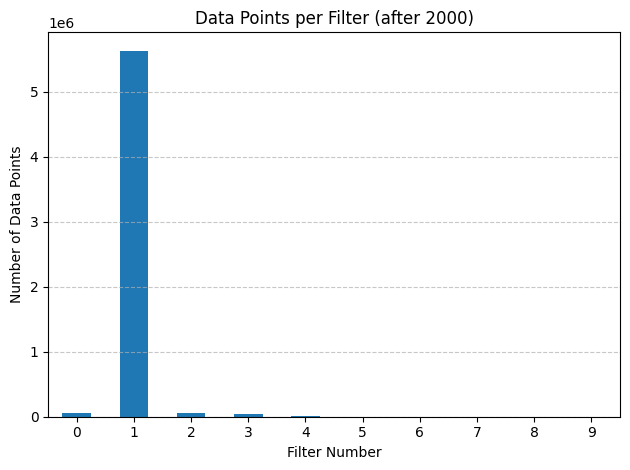

{0: 50000, 1: 5634783, 2: 54532, 3: 40193, 4: 4915, 5: 2206, 6: 2211, 7: 1797, 8: 1064, 9: 54}


In [84]:
counts = count_points_by_filter(df)
print(counts)

In [86]:
n_unique_wells = df_after_2000['Well_ID'].nunique()
print(f"Number of unique wells: {n_unique_wells}")

Number of unique wells: 1048


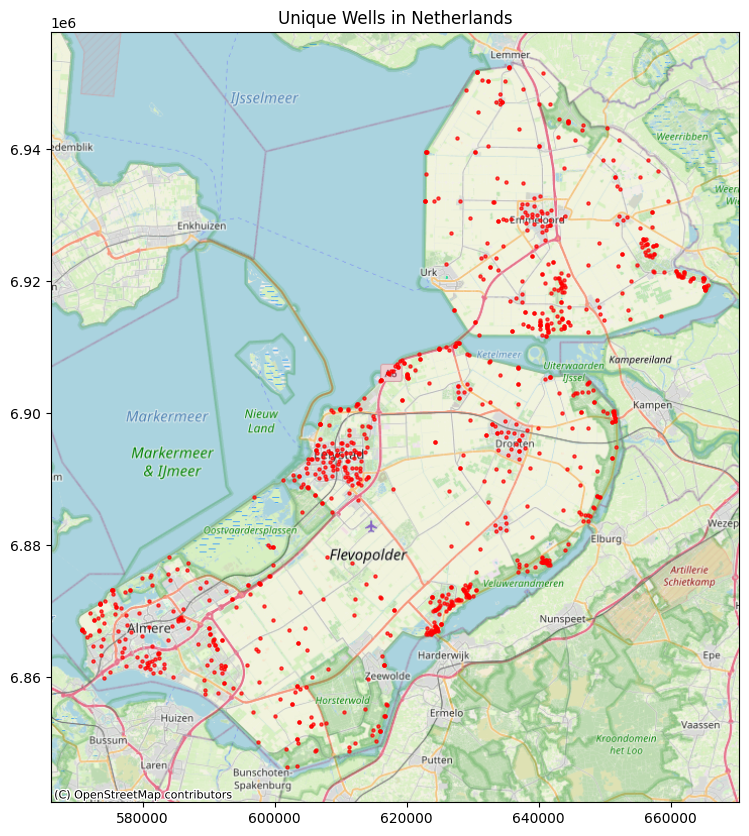

In [85]:
plot_points(df_after_2000)

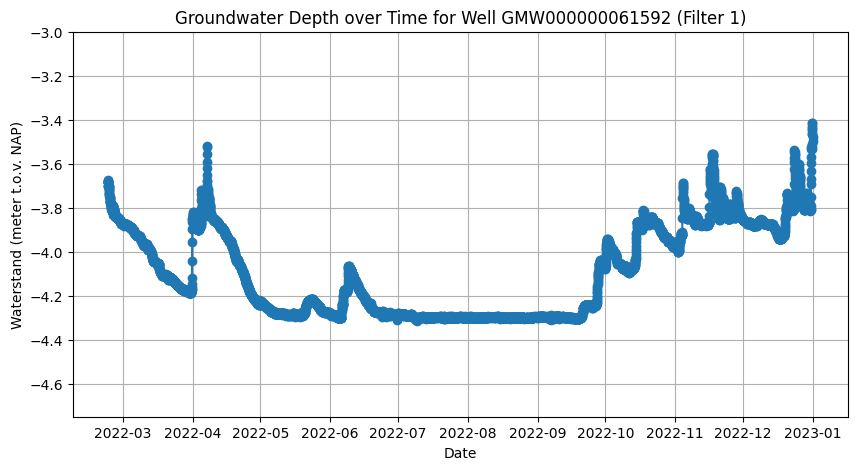

In [130]:
plot_timeseries_for_well(df_after_2000, "GMW000000061592")